# Setup

In [46]:
import getpass
import os
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from langchain_core.prompts import PromptTemplate
import time, tiktoken, pandas as pd, datetime as dt, pathlib

In [47]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter API key for LangSmith: ")
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

Enter API key for LangSmith:  ········
Enter API key for OpenAI:  ········


In [48]:
model = "gpt-4o-mini"
llm = init_chat_model(model, model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# all embeddings have the ssame fixed dimensions and each model uses its own architecture which outputs different vector length
embedding_dim = len(embeddings.embed_query("hello world")) 
# FAISS is a vector searcxh library that needs to know in advance how many numbers each vector will have
index = faiss.IndexFlatL2(embedding_dim)

# FAISS operate over flat arrays of vectors. They do not understand nested structure
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

# Indexing

## Splitting Documents

In [49]:
def load_pdfs(file_path):
    loader = PyPDFLoader(file_path, mode="page")
    pages = []

    for page in loader.load():
        pages.append(page)    

    # The textbook PDFs are natrually organized into hierarchical units such as paragraphs, sentences, and words
    # RecursiveCharacterTextSplitter try to split the text in a natural and structured way
    # Try split paragrah --> too long = split by sentence --> too long = split by word --> too long = split raw characters
    # this allows each chunks to keep their semnantic meaning
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) 
    # experiment with chunk_size and measuire retrieval accuracy, relevance of responses, speed/cost
    # consider annotating each chunk with metadata such as filename, page_number, chapter for retrieval
    splits = text_splitter.split_documents(pages)

    return splits

## Storing documents

In [51]:
file_paths = ["data/complexityprivacy_1.pdf",
            "data/privacybook.pdf"]

for file_path in file_paths:
    _ = vector_store.add_documents(load_pdfs(file_path))

# Retrieval and Generation

## Application Logic

In [52]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    # generate prompt string from prompt object for token counting
    prompt_string = prompt.format(context=docs_content, question=state["question"])
    
    start = time.time()
    encoding = tiktoken.encoding_for_model(model)
    prompt_tokens = len(encoding.encode(prompt_string)) # encode needs a string object
    
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    response_tokens = len(encoding.encode(response.content))
    latency = time.time() - start
    
    log_row = {
        "timestamp": dt.datetime.now().isoformat(),
        "query": state["question"],
        "response": response.content,
        "prompt_tokens": prompt_tokens,
        "response_tokens": response_tokens,
        "total_tokens": prompt_tokens + response_tokens,
        "latency_sec": latency,
        "model": "gpt-4o-mini",
    }

    log_path = pathlib.Path("logs.csv")
    pd.DataFrame([log_row]).to_csv("logs.csv", mode="a", index=False, header=not pathlib.Path("logs.csv").exists())
    
    return {"answer": response.content}

## Control Flow

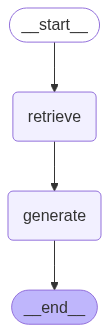

In [53]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

## Usage

In [54]:
template = """
Imagine you are an angry yet passionate professor who wants to encourage a failing and dumb student. Try to dumb things down as much as possible, but
also make sure the student understand the context and fundamental behind the question being asked as well. Use the following pieces of context
to answer the question at the end. If you don't know the answer, say you don't know, don't try to make up an answer. aLways say "Man I need some coffee"
at the end of the answer.
{context}

Question: {question}
"""

prompt = PromptTemplate.from_template(template)

In [55]:
for step in graph.stream(
    {"question": "What are the two PDFs about?"}, stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='eea3da3b-ef3a-492d-b746-c2d89af3df6c', metadata={'producer': 'pdfTeX-1.40.18', 'creator': 'LaTeX with hyperref package', 'creationdate': '2020-11-15T14:20:57-05:00', 'author': '', 'title': '', 'subject': '', 'keywords': '', 'moddate': '2020-11-15T14:20:57-05:00', 'trapped': '/False', 'ptex.fullbanner': 'This is MiKTeX-pdfTeX 2.9.6499 (1.40.18)', 'source': 'data/privacybook.pdf', 'total_pages': 281, 'page': 263, 'page_label': '260'}, page_content='Appendices'), Document(id='197e0dae-8ee3-44b2-950a-c0571a4a3e44', metadata={'producer': 'pdfTeX-1.40.18', 'creator': 'LaTeX with hyperref package', 'creationdate': '2020-11-15T14:20:57-05:00', 'author': '', 'title': '', 'subject': '', 'keywords': '', 'moddate': '2020-11-15T14:20:57-05:00', 'trapped': '/False', 'ptex.fullbanner': 'This is MiKTeX-pdfTeX 2.9.6499 (1.40.18)', 'source': 'data/privacybook.pdf', 'total_pages': 281, 'page': 6, 'page_label': '3'}, page_content='Preface\nThe problem of privacy-pres